In [1]:
from MyImports import *
from ModelTrainingUtils import plot_accuracy,plot_loss, classwise_accuracy, process_image, predict_image_class
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
train_path = Path('./images/train')
test_path = Path('./images/test')

In [3]:
# Resize train data and split the data for validation.
train_ds = tf.keras.utils.image_dataset_from_directory(directory = train_path,
                                                       label_mode = 'categorical',
                                                       batch_size = 32,
                                                       image_size = image_size,
                                                       seed = 2022,
                                                       validation_split = 0.2,
                                                       subset = "training",
                                                       shuffle=True)

Found 3135 files belonging to 4 classes.
Using 2508 files for training.


In [4]:
valid_ds = tf.keras.utils.image_dataset_from_directory(directory = train_path,
                                                       label_mode = 'categorical',
                                                       batch_size = 32,
                                                       image_size = image_size,
                                                       seed = 2022,
                                                       validation_split = 0.2,
                                                       subset = "validation")

Found 3135 files belonging to 4 classes.
Using 627 files for validation.


In [5]:
test_ds = tf.keras.utils.image_dataset_from_directory(directory = test_path,
                                                       label_mode = 'categorical',
                                                       batch_size = 32,
                                                       image_size = image_size,
                                                       seed = 2022,
                                                       shuffle = False
                                                      )

Found 351 files belonging to 4 classes.


In [6]:
class_names = test_ds.class_names  # list of class names

In [8]:
#Data Augmentation
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(height_factor = 0.2, width_factor=0.2)
])

aug_ds = train_ds

for image, label in aug_ds :
  image = augmentation(image)

In [11]:
model_CNN = tf.keras.Sequential([

tf.keras.layers.InputLayer(input_shape = [image_size[0], image_size[1], 3]),
tf.keras.layers.Rescaling(1./255),


tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'),
tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'),
tf.keras.layers.MaxPool2D(pool_size = (2,2)),

tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'),
tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'),
tf.keras.layers.MaxPool2D(pool_size = (2,2)),

tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation = 'relu'),

tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dense(4, activation = 'softmax')
])

In [12]:
model_CNN.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy', 'Precision', 'Recall'])

In [13]:
log_dir = "./logs/CNNN"

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("CNN.keras", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', patience = 3, restore_best_weights=True
)

In [14]:
history_CNN = model_CNN.fit(aug_ds, validation_data = valid_ds, epochs = 30, callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb])

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - Precision: 0.1500 - Recall: 1.2341e-04 - accuracy: 0.2923 - loss: 1.3566 - val_Precision: 1.0000 - val_Recall: 0.0064 - val_accuracy: 0.4530 - val_loss: 1.2278
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - Precision: 0.8409 - Recall: 0.1417 - accuracy: 0.5642 - loss: 1.1000 - val_Precision: 0.7846 - val_Recall: 0.4705 - val_accuracy: 0.6427 - val_loss: 0.8234
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - Precision: 0.7981 - Recall: 0.5474 - accuracy: 0.6981 - loss: 0.7718 - val_Precision: 0.8132 - val_Recall: 0.6108 - val_accuracy: 0.7065 - val_loss: 0.7196
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - Precision: 0.8109 - Recall: 0.6306 - accuracy: 0.7295 - loss: 0.7141 - val_Precision: 0.8172 - val_Recall: 0.6204 - val_accuracy: 0.7257 - val_loss: 0.7015
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - Precision: 0.8216 - Recall: 0.6599 - accuracy: 0.7489 - loss: 0.6531 - val_Precision: 0.8109 - val_Recall: 

In [15]:
model_CNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 419,822 (1.60 MB)

 Trainable params: 139,940 (546.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 279,882 (1.07 MB)

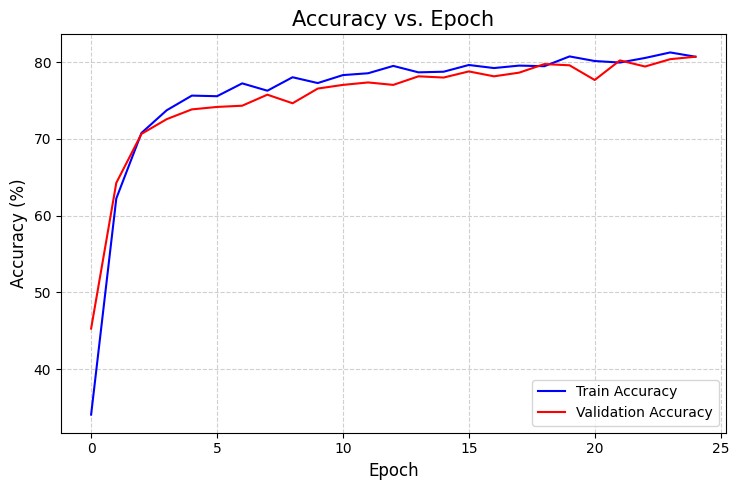

In [16]:
plot_accuracy(history_CNN)

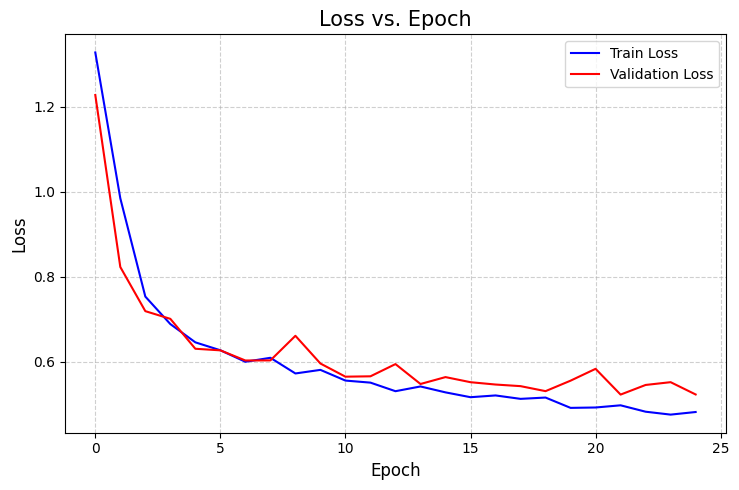

In [17]:
plot_loss(history_CNN)

In [18]:
y_true = tf.concat([y for x, y in test_ds], axis=0).numpy()
if y_true.ndim > 1:  # one-hot or multi-label
    y_true = y_true.argmax(axis=1)  # convert one-hot to integer labels


In [19]:
#y_true = tf.concat([y for x, y in test_ds], axis=0).numpy()
y_pred_probs = model_CNN.predict(test_ds)
y_pred = tf.argmax(y_pred_probs, axis=1).numpy()

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 391ms/step


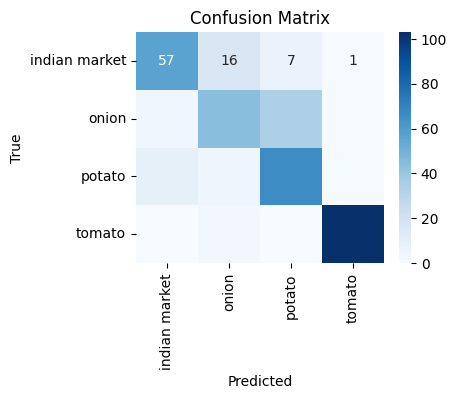

               precision    recall  f1-score   support

indian market       0.81      0.70      0.75        81
        onion       0.65      0.53      0.58        83
       potato       0.62      0.81      0.70        81
       tomato       0.97      0.97      0.97       106

     accuracy                           0.77       351
    macro avg       0.76      0.76      0.75       351
 weighted avg       0.78      0.77      0.77       351



In [23]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Optional: print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

"""
Confusion did not render the annotations correctly in jupyter notebook running on vscode editor. hence y_pred and y_true values were run on colab to give the annoted confusion matrix as below.
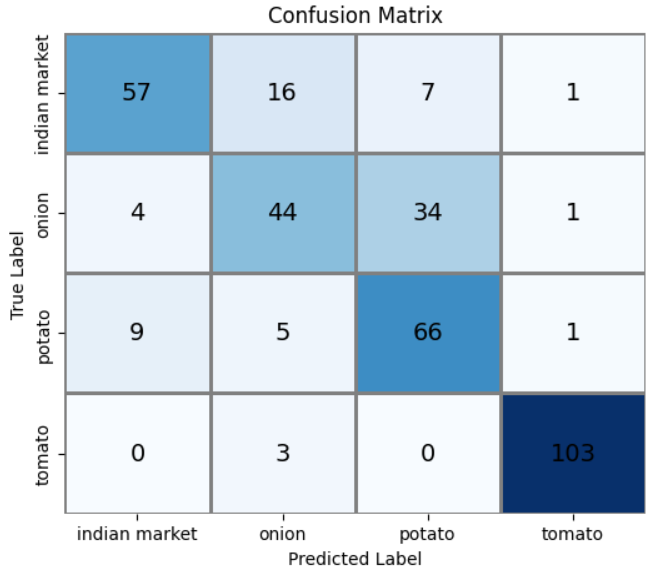
"""

In [24]:
classwise_accuracy(test_path,model_CNN,class_names)

✅ Accuracy for class 'indian market': 69.14% (81 images)
✅ Accuracy for class 'onion': 54.22% (83 images)
✅ Accuracy for class 'potato': 77.78% (81 images)
✅ Accuracy for class 'tomato': 97.17% (106 images)


In [ ]:
"""
Overall Accuracy:

77% accuracy is reasonable, showing that the model performs fairly well overall.

Tomato Detection is Excellent:

Very high precision and recall (~97%) show the model confidently and correctly classifies tomatoes.

Possibly due to distinctive features or better representation in training data.

Onion and Potato Need Work:

Onion has low precision (0.65) and low recall (0.53) → many false positives and false negatives.

Potato has low precision (0.62) but high recall (0.81) → catches most potatoes but also misclassifies other classes as potato.

Likely causes: visual similarity between onion and potato, or data imbalance/quality issues.

Indian Market Class is Decent:

Precision (0.81) is higher than recall (0.70), meaning the model is cautious and avoids misclassifying other images as "Indian market."

Macro vs Weighted Avg:

Macro avg F1 = 0.75: Equal weight to each class.

Weighted avg F1 = 0.77: More influenced by the excellent performance on tomato (largest support).

This indicates some class imbalance, which skews the overall metrics positively.

"""

In [23]:
model_CNN.evaluate(test_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 395ms/step - Precision: 0.7689 - Recall: 0.7058 - accuracy: 0.7501 - loss: 0.5407


[0.5218650698661804,
 0.7606837749481201,
 0.7863777279853821,
 0.7236467003822327]

In [9]:
# RESNET model
model_resnet = tf.keras.applications.resnet50.ResNet50(input_shape=(256, 256, 3), include_top = False)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [10]:
transfer_model_RESNET = model_resnet.output

transfer_model_RESNET = tf.keras.Sequential([
            #Normalizing 0-255 into 0 to 1
            tf.keras.layers.InputLayer(input_shape=[image_size[0], image_size[1], 3]),
            tf.keras.layers.Rescaling(1./255),
            model_resnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(rate = 0.1),
            tf.keras.layers.Dense(4, activation = 'softmax')
        ])

In [11]:
transfer_model_RESNET.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy', 'Precision', 'Recall'])

In [13]:
log_dir = "logs/ResNet"

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("ProduceClassifier.keras", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', patience = 5, restore_best_weights=True
)

In [15]:
history_resnet = transfer_model_RESNET.fit(aug_ds, validation_data = valid_ds, epochs = 20, callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb])

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 737s 9s/step - Precision: 0.9988 - Recall: 0.9985 - accuracy: 0.9985 - loss: 0.0082 - val_Precision: 0.2121 - val_Recall: 0.2121 - val_accuracy: 0.2121 - val_loss: 3.2116
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 785s 10s/step - Precision: 0.9977 - Recall: 0.9977 - accuracy: 0.9977 - loss: 0.0067 - val_Precision: 0.2125 - val_Recall: 0.2121 - val_accuracy: 0.2121 - val_loss: 3.1880
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 725s 9s/step - Precision: 0.9988 - Recall: 0.9988 - accuracy: 0.9988 - loss: 0.0039 - val_Precision: 0.1511 - val_Recall: 0.0957 - val_accuracy: 0.2376 - val_loss: 1.8809
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 715s 9s/step - Precision: 0.9965 - Recall: 0.9965 - accuracy: 0.9965 - loss: 0.0098 - val_Precision: 0.3185 - val_Recall: 0.2504 - val_accuracy: 0.3254 - val_loss: 2.1282
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 709s 9s/step - Precision: 0.9934 - Recall: 0.9929 - accuracy: 0.9931 - loss: 0.0301 - val_Precision: 0.4087 - val_Recall: 0.3

KeyboardInterrupt: 

In [16]:
transfer_model_RESNET.evaluate(test_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - Precision: 0.9205 - Recall: 0.9205 - accuracy: 0.9205 - loss: 0.7438


[0.646940290927887, 0.9259259104728699, 0.9259259104728699, 0.9259259104728699]

11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step


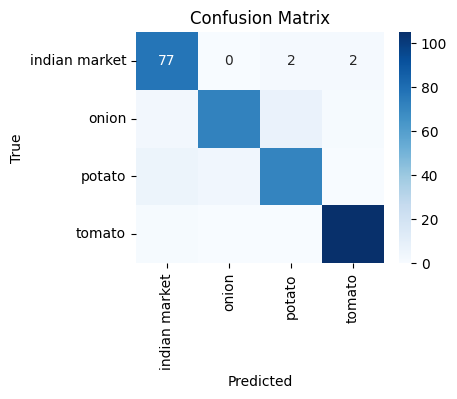

               precision    recall  f1-score   support

indian market       0.89      0.95      0.92        81
        onion       0.95      0.87      0.91        83
       potato       0.89      0.88      0.88        81
       tomato       0.97      0.99      0.98       106

     accuracy                           0.93       351
    macro avg       0.92      0.92      0.92       351
 weighted avg       0.93      0.93      0.93       351



In [18]:
y_true = tf.concat([y for x, y in test_ds], axis=0).numpy()
if y_true.ndim > 1:  # one-hot or multi-label
    y_true = y_true.argmax(axis=1)  # convert one-hot to integer labels

#y_true = tf.concat([y for x, y in test_ds], axis=0).numpy()
y_pred_probs = transfer_model_RESNET.predict(test_ds)
y_pred = tf.argmax(y_pred_probs, axis=1).numpy()

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Optional: print classification report
print(classification_report(y_true, y_pred, target_names=class_names))


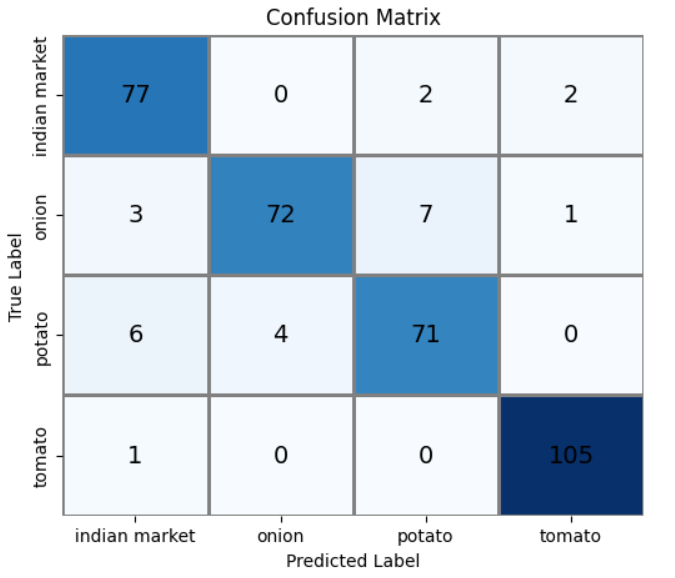

In [22]:
classwise_accuracy(test_path,transfer_model_RESNET,class_names)

✅ Accuracy for class 'indian market': 95.06% (81 images)
✅ Accuracy for class 'onion': 86.75% (83 images)
✅ Accuracy for class 'potato': 87.65% (81 images)
✅ Accuracy for class 'tomato': 99.06% (106 images)


Overall Accuracy: 93% – Excellent, indicating the model predicts the correct class in the vast majority of cases.

Macro and Weighted Averages (Precision, Recall, F1-score): All at 0.92–0.93, showing balanced performance across classes, even if the support varies.

tomato class is extremely well-learned.

The model handles the noisy "Indian market" class effectively.

Balanced performance across produce classes, even with slightly imbalanced support.